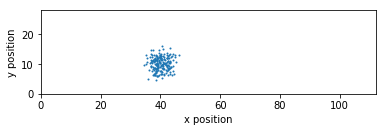

46.14772200465492
15.965703208851679


In [1]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import make_random_selfdata
from PIL import Image, ImageDraw
import train_myrcvae
import net
import chainer
from chainer import serializers
%matplotlib inline

In [2]:
def read_csv(csv_file):
    df = pd.read_csv(csv_file, sep=',', header=None)
    len_cols = len(df)
    image_name = df.loc[0:len_cols,0]
    x = np.array(df.loc[0:len_cols,1], np.float32)
    y = np.array(df.loc[0:len_cols,2], np.float32)
    th = np.array(df.loc[0:len_cols,3], np.float32)
    return image_name, x, y, th
def separetePosition_and_angle_probabilityMap(data, data_len, border):
    angle_map_l = len(data[0]) - border 
    pos_map = np.zeros((data_len, border), dtype=np.float32)
    angle_map = np.zeros((data_len, angle_map_l), dtype=np.float32)
    for n in range(data_len):
        pos_map[n,:] = data[n][0:border]
        angle_map[n,:] = data[n][border:]
    return pos_map, angle_map

In [10]:
class Plot:
    def __init__(self, make_random_selfdata_cls):
        self.disp_image_ratio = 150
        self.pred_pos_map_ratio = 150
        self.field_w = make_random_selfdata_cls.field_w
        self.field_h = make_random_selfdata_cls.field_h
        self.vrep_onehot_w = make_random_selfdata_cls.vrep_onehot_w
        self.vrep_onehot_h = make_random_selfdata_cls.vrep_onehot_h
        self.field_img = Image.open("hukan.png")
        self.r = 2
        self.robot_color = "black"
        self.field_mergin = 5

    def plotRobot(self, x, y, th, ax):
        #rx, ry = plot_cls.convertVrepPos2PosMapValue(x, y, 10)rx, ry = plot_cls.convertVrepPos2PosMapValue(x, y, 10)
        xn = x + self.r * math.cos(th)
        yn = y + self.r * math.sin(th)
        #ax.plot([x.astype(np.int64), xn.astype(np.int64)], [y.astype(np.int64), yn.astype(np.int64)], color="black", linewidth=2)
        ax.plot([x, xn], [y, yn], color="black", linewidth=2)
        c = patch.Circle(xy=(x, y), radius=self.r, fill=False, color="black", linewidth=2)
        ax.add_patch(c)
    def plotParticle(self, particles, ax): # x, y, th, weight
        #pos2D = [self.convertVrepPos2PosMapValue(p.pose[0], p.pose[1], 10) for p in particles]
        xs = [p.pose[0]+self.field_mergin for p in particles]
        ys = [p.pose[1]+self.field_mergin for p in particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(particles) for p in particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(particles) for p in particles]  #重みを要素に反映
        #vxs = [math.cos(p.pose[2])*p.weight for p in particles] #重みを要素に反映
        #vys = [math.sin(p.pose[2])*p.weight for p in particles]  #重みを要素に反映
        ax.quiver(xs, ys, vxs, vys, angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.7) #変更
    def plotUpdate(self, x, y, th, particle, ax):
        self.plotRobot(x+self.field_mergin, y+self.field_mergin, th,ax)
        self.plotParticle(particle, ax)
        ax.imshow(self.field_img)
        plt.show()
    def convertVrepPos2DisplayPosValue(self, x, y): # Vrep の座標系から，表示のために倍率を変えてる
        f_w = self.field_w
        f_h = self.field_h
        x = (x + f_w/2)/self.disp_image_ratio #+ self.field_mergin
        y = int(self.field_h/self.disp_image_ratio) - (y + f_h/2)/self.disp_image_ratio# + self.field_mergin
        return x, y

In [4]:
class Particle():
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
    def motion_update(self, x, y, th, pre_x, pre_y, pre_th):
        #適当なランダムを加えながらモーションアップデートする（真値の1番目ー0番目）
        x, y = plot_cls.convertVrepPos2DisplayPosValue(x, y)
        pre_x, pre_y = plot_cls.convertVrepPos2DisplayPosValue(pre_x, pre_y)
        px = x - pre_x + np.random.normal(-0.5, 0.5 , 1)[0]
        py = y - pre_y + np.random.normal(-0.5, 0.5, 1)[0]
        pth = th - pre_th
        dx =  self.pose[0] + px 
        dy = self.pose[1] + py 
        dth = self.pose[2] + pth
        return [dx, dy, dth]
    def observation_update(self, pos_map, angle_map):
        m_x, m_y = self.Map2weight(pos_map, angle_map)
        m_x = int(m_x)
        m_y = int(m_y)
        alpha = 0.6
        self.weight = alpha*self.weight + (1-alpha)*pos_map[m_y,m_x]
    def Map2weight(self, pos_map, angle_map):
        f_w = plot_cls.field_w
        f_h = plot_cls.field_h
        x = (self.pose[0] + f_w/2)/plot_cls.disp_image_ratio + plot_cls.field_mergin
        y = int(plot_cls.field_h/plot_cls.disp_image_ratio) - (self.pose[1] + f_h/2)/plot_cls.disp_image_ratio + plot_cls.field_mergin
        return int(x), int(y)
    def convertDisplayPosValue2predPosMapValue(self, x, y):
        x = (x-1)*plot_cls.disp_image_ratio/plot_cls.pred_pos_map_ratio
        y = (y-1)*plot_cls.disp_image_ratio/plot_cls.pred_pos_map_ratio
        return x, y

In [5]:
class Robot:
    def __init__(self, init_x, init_y, init_theta):
        self.init_x = init_x
        self.init_y = init_y
        self.init_theta = init_theta
    def motion_update(self, x, y, th):
        #csv から位置を更新
        rx, ry = plot_cls.convertVrepPos2DisplayPosValue(x, y)
        return rx, ry, th
    def observation_update():
        pass

In [6]:
class CVAE:
    def __init__(self):
        self.NLABELDIM = 1200
        self.CONTEXTDIM = 5701
        self.NZDIM = 1
        self.HIDDEN = 1200
        self.z = chainer.Variable(np.zeros((1, 1), dtype=np.float32))
        self.model = net.MyCVAE(self.CONTEXTDIM, self.NZDIM, self.HIDDEN, self.NLABELDIM)
        serializers.load_npz("mymodel_final.npz", self.model)
        self.pos_map = np.zeros((plot_cls.vrep_onehot_w*plot_cls.vrep_onehot_h), dtype=np.float32)
        self.angle_map = np.zeros((40*80), dtype=np.float32)
    def pred_CVAE(self, image_name):
        value = np.zeros((1, 40*30), dtype=np.float32)
        img = np.ravel(Image.open(image_name))
        img = img.astype(np.float32)
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x = self.model.decode(self.z, np.expand_dims(img, axis=0))
        self.pos_map, self.angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), plot_cls.vrep_onehot_w* plot_cls.vrep_onehot_h)
    def getMaps(self):
        pos_map_mat = np.reshape(self.pos_map, (plot_cls.vrep_onehot_h, plot_cls.vrep_onehot_w))
        angle_map_mat = np.reshape(self.angle_map,(40,80))
        return pos_map_mat, angle_map_mat
    def dammyGetMaps(self):
        pos_map_mat = np.reshape(self.pos_map, (plot_cls.vrep_onehot_h, plot_cls.vrep_onehot_w))
        pos_map_mat = cv2.imread("dammy_pos_map.jpg", -1)
        angle_map_mat = np.reshape(self.angle_map,(40,80))
        return pos_map_mat, angle_map_mat

In [7]:
def returnKidoAxisFropmPosMap(pos_map):
    kido = np.empty((0,2), dtype=np.float32)
    for h in range(pos_map.shape[0]):
        for w in range(pos_map.shape[1]):
            if(pos_map[h, w] > 0):
                #print("!!!!!!!!!!!!")
                #kido = [w,h]
                kido = np.append(kido, np.array([[w,h]]), axis=0)
                #print(kido)
    #print(kido)
    return kido

0


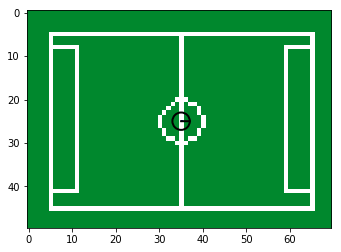

1
255 pos_map values


<Figure size 432x288 with 0 Axes>

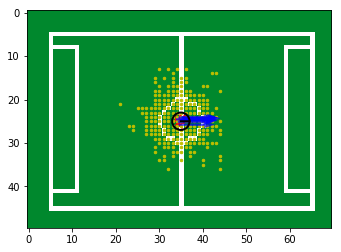

2
255 pos_map values


<Figure size 432x288 with 0 Axes>

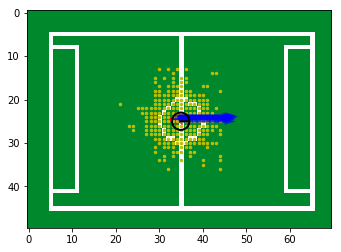

3
255 pos_map values


<Figure size 432x288 with 0 Axes>

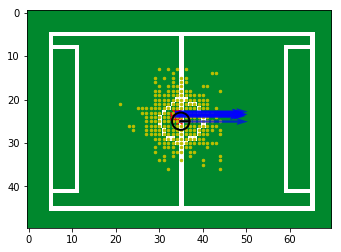

4
255 pos_map values


<Figure size 432x288 with 0 Axes>

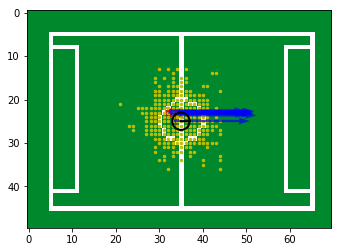

5
255 pos_map values


<Figure size 432x288 with 0 Axes>

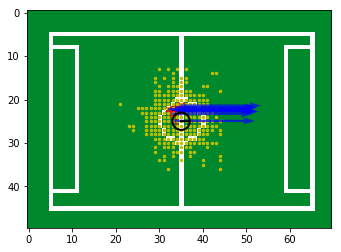

6
255 pos_map values


<Figure size 432x288 with 0 Axes>

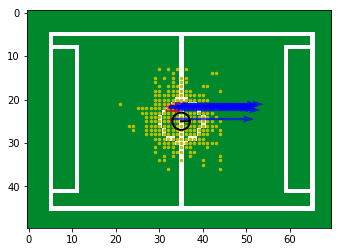

7
255 pos_map values


<Figure size 432x288 with 0 Axes>

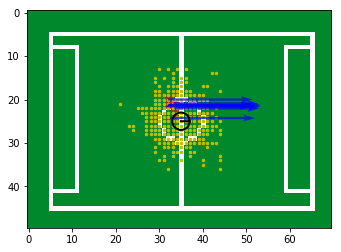

8
255 pos_map values


<Figure size 432x288 with 0 Axes>

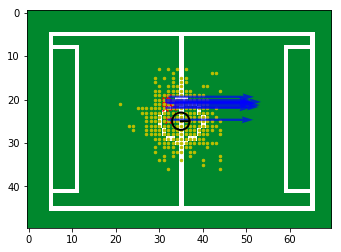

9
255 pos_map values


<Figure size 432x288 with 0 Axes>

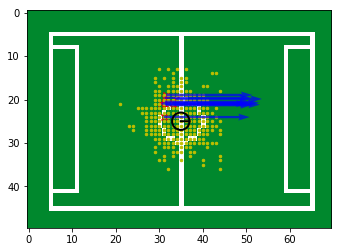

10
255 pos_map values


<Figure size 432x288 with 0 Axes>

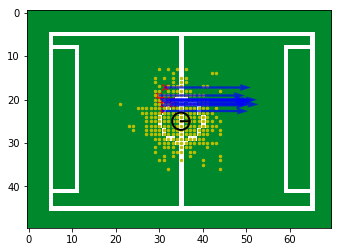

11
255 pos_map values


<Figure size 432x288 with 0 Axes>

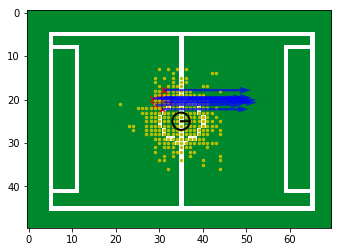

12
255 pos_map values


<Figure size 432x288 with 0 Axes>

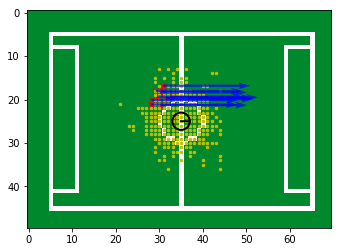

13
255 pos_map values


<Figure size 432x288 with 0 Axes>

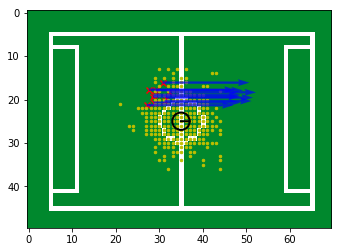

14
255 pos_map values


<Figure size 432x288 with 0 Axes>

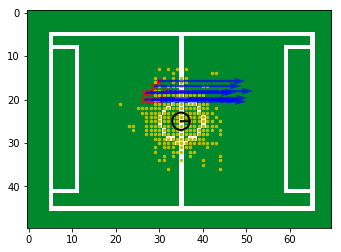

15
255 pos_map values


<Figure size 432x288 with 0 Axes>

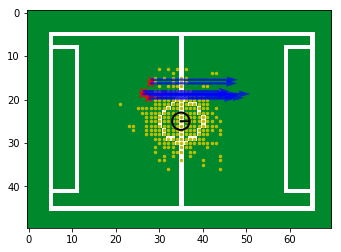

16
255 pos_map values


<Figure size 432x288 with 0 Axes>

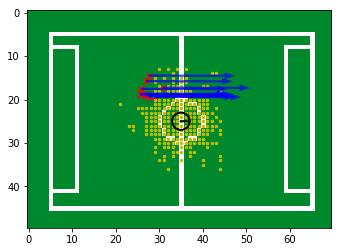

17
255 pos_map values


<Figure size 432x288 with 0 Axes>

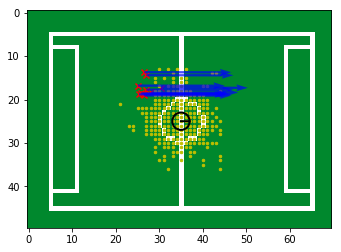

18
255 pos_map values


<Figure size 432x288 with 0 Axes>

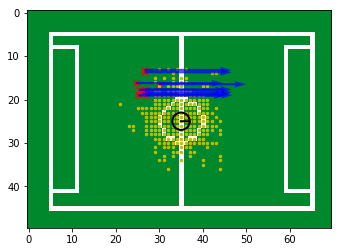

19
255 pos_map values


<Figure size 432x288 with 0 Axes>

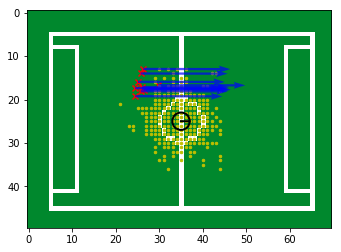

20
255 pos_map values


<Figure size 432x288 with 0 Axes>

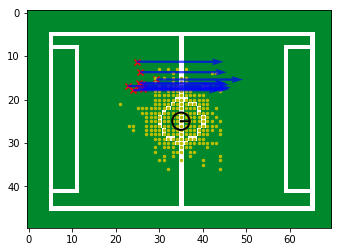

21
255 pos_map values


<Figure size 432x288 with 0 Axes>

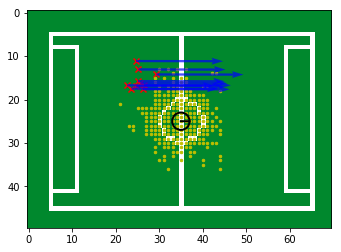

22
255 pos_map values


<Figure size 432x288 with 0 Axes>

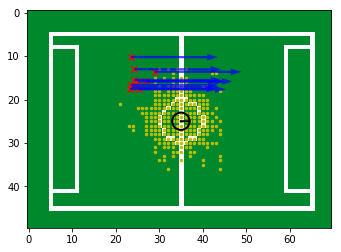

23
255 pos_map values


<Figure size 432x288 with 0 Axes>

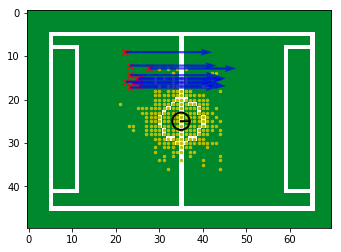

24
255 pos_map values


<Figure size 432x288 with 0 Axes>

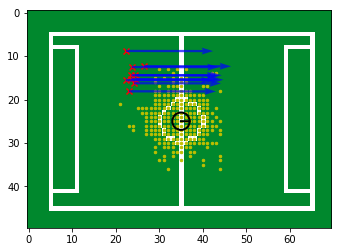

25
255 pos_map values


<Figure size 432x288 with 0 Axes>

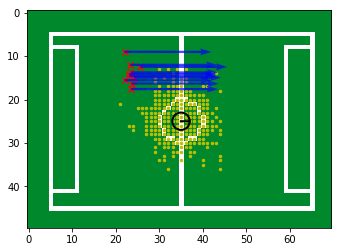

26
255 pos_map values


<Figure size 432x288 with 0 Axes>

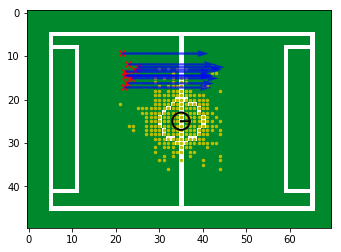

27
255 pos_map values


<Figure size 432x288 with 0 Axes>

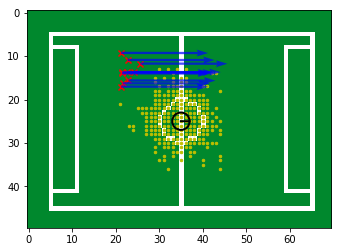

28
255 pos_map values


<Figure size 432x288 with 0 Axes>

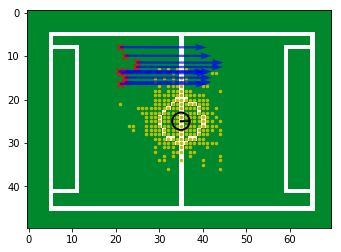

29
255 pos_map values


<Figure size 432x288 with 0 Axes>

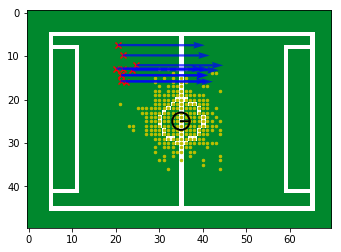

30
255 pos_map values


<Figure size 432x288 with 0 Axes>

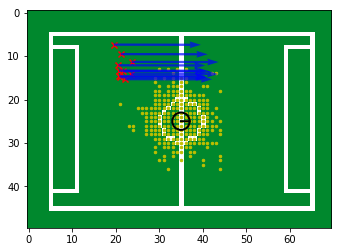

31
255 pos_map values


<Figure size 432x288 with 0 Axes>

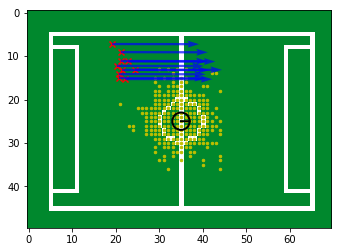

32
255 pos_map values


<Figure size 432x288 with 0 Axes>

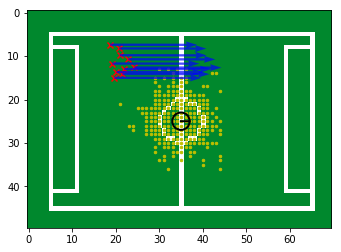

33
255 pos_map values


<Figure size 432x288 with 0 Axes>

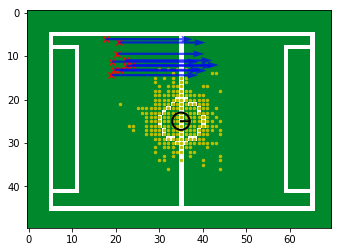

34
255 pos_map values


<Figure size 432x288 with 0 Axes>

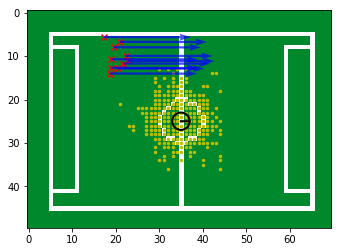

35
255 pos_map values


<Figure size 432x288 with 0 Axes>

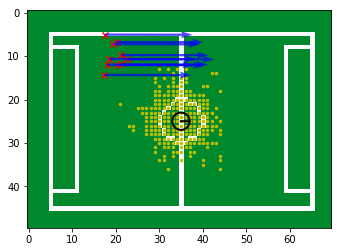

36
255 pos_map values


<Figure size 432x288 with 0 Axes>

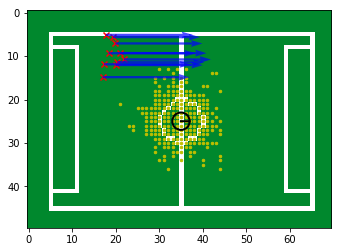

37
255 pos_map values


<Figure size 432x288 with 0 Axes>

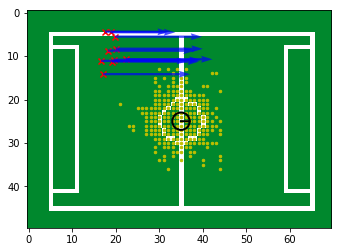

38
255 pos_map values


<Figure size 432x288 with 0 Axes>

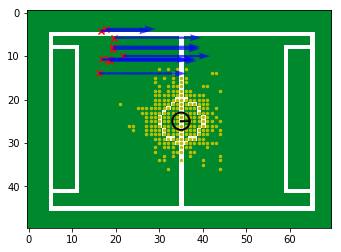

39
255 pos_map values


<Figure size 432x288 with 0 Axes>

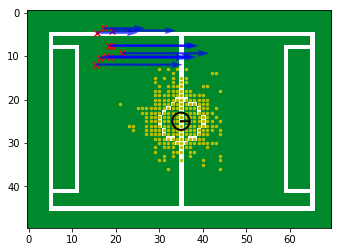

40
255 pos_map values


<Figure size 432x288 with 0 Axes>

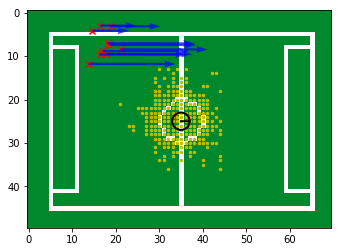

41
255 pos_map values


<Figure size 432x288 with 0 Axes>

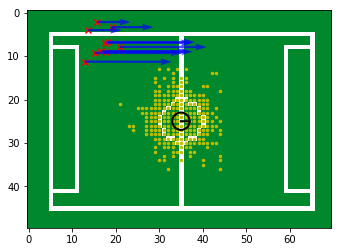

42
255 pos_map values


<Figure size 432x288 with 0 Axes>

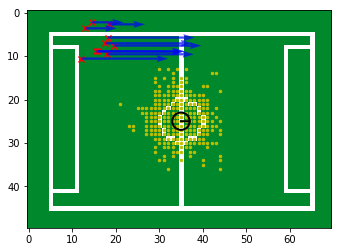

43
255 pos_map values


<Figure size 432x288 with 0 Axes>

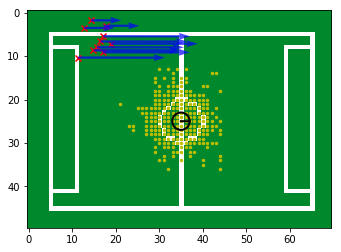

44
255 pos_map values


<Figure size 432x288 with 0 Axes>

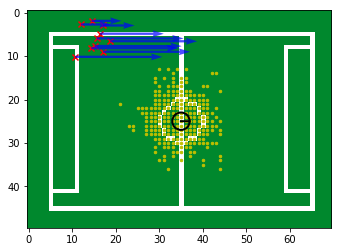

45
255 pos_map values


<Figure size 432x288 with 0 Axes>

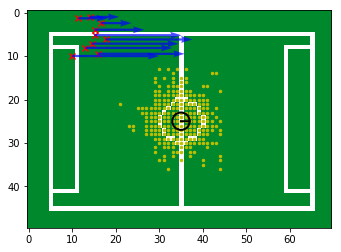

46
255 pos_map values


<Figure size 432x288 with 0 Axes>

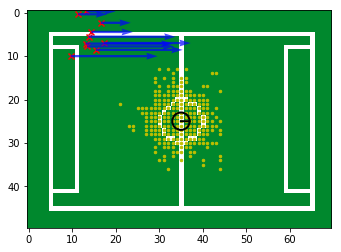

47
255 pos_map values


<Figure size 432x288 with 0 Axes>

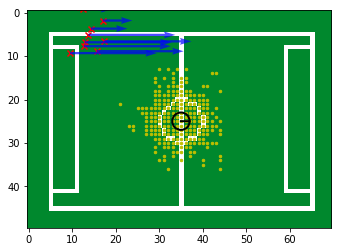

48
255 pos_map values


<Figure size 432x288 with 0 Axes>

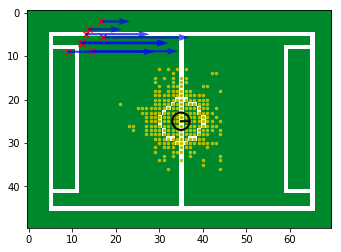

49
255 pos_map values


<Figure size 432x288 with 0 Axes>

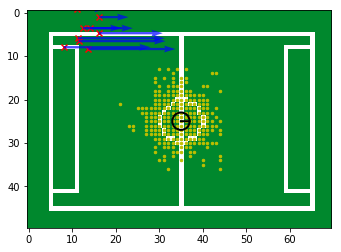

50
255 pos_map values


<Figure size 432x288 with 0 Axes>

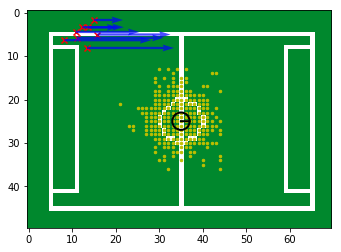

51
255 pos_map values


<Figure size 432x288 with 0 Axes>

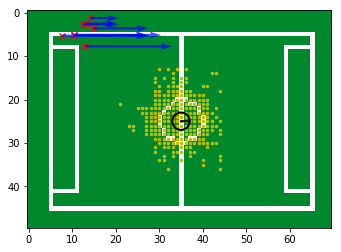

52
255 pos_map values


<Figure size 432x288 with 0 Axes>

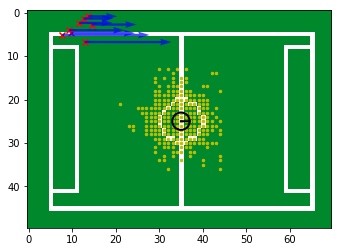

53
255 pos_map values


<Figure size 432x288 with 0 Axes>

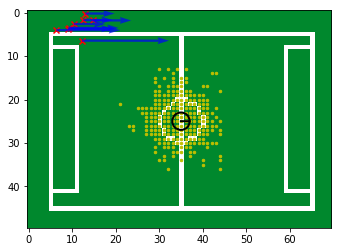

54
255 pos_map values


<Figure size 432x288 with 0 Axes>

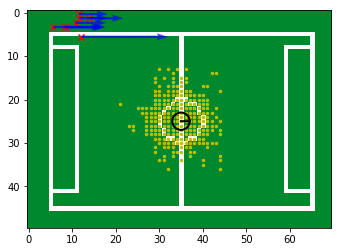

55
255 pos_map values


<Figure size 432x288 with 0 Axes>

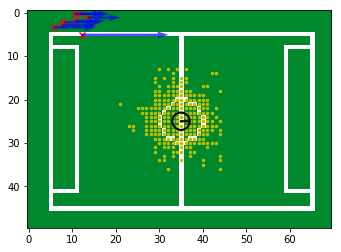

56
255 pos_map values


<Figure size 432x288 with 0 Axes>

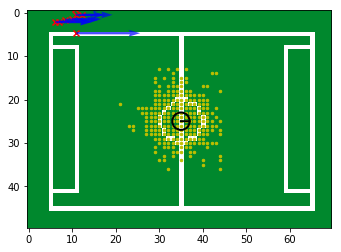

57
255 pos_map values


<Figure size 432x288 with 0 Axes>

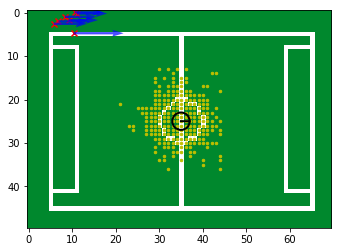

58
255 pos_map values


<Figure size 432x288 with 0 Axes>

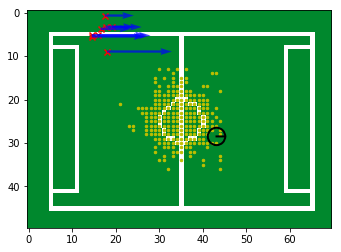

59
255 pos_map values


<Figure size 432x288 with 0 Axes>

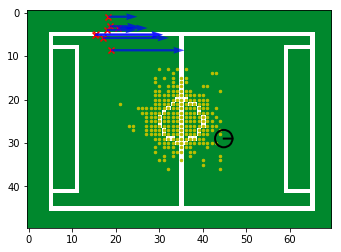

60
255 pos_map values


<Figure size 432x288 with 0 Axes>

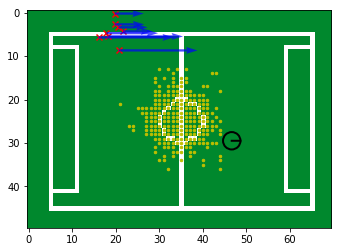

61
255 pos_map values


<Figure size 432x288 with 0 Axes>

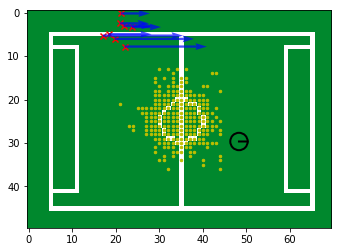

62
255 pos_map values


<Figure size 432x288 with 0 Axes>

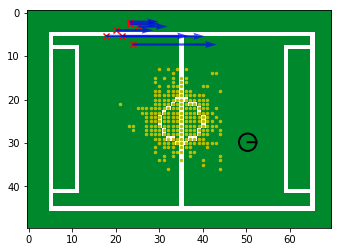

63
255 pos_map values


<Figure size 432x288 with 0 Axes>

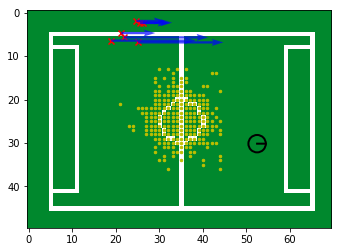

64
255 pos_map values


<Figure size 432x288 with 0 Axes>

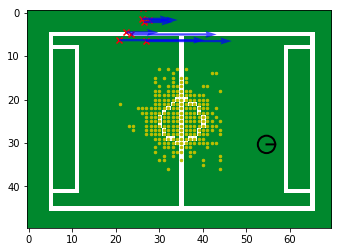

65
255 pos_map values


<Figure size 432x288 with 0 Axes>

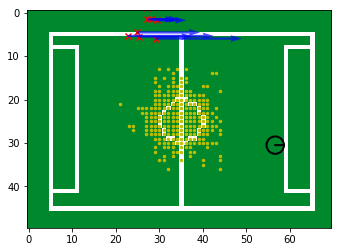

66
255 pos_map values


<Figure size 432x288 with 0 Axes>

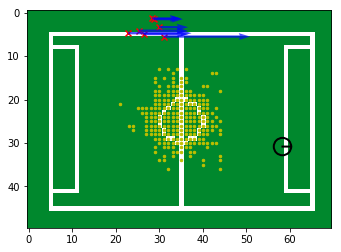

67
255 pos_map values


<Figure size 432x288 with 0 Axes>

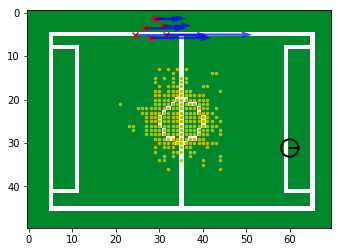

68
255 pos_map values


<Figure size 432x288 with 0 Axes>

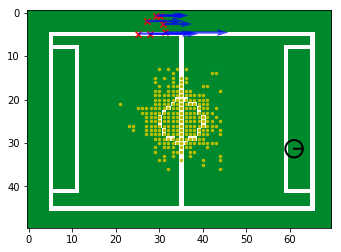

69
255 pos_map values


<Figure size 432x288 with 0 Axes>

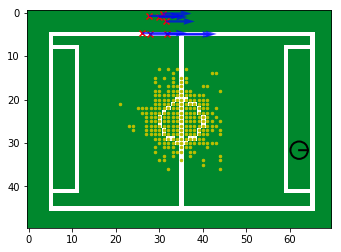

70
255 pos_map values


<Figure size 432x288 with 0 Axes>

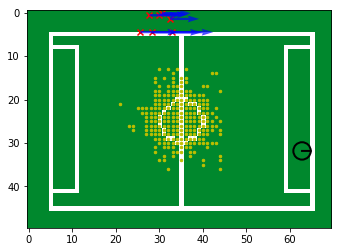

71
255 pos_map values


<Figure size 432x288 with 0 Axes>

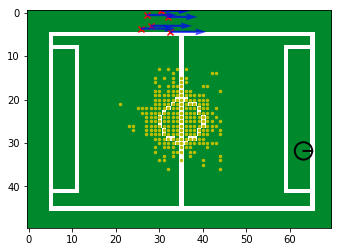

72
255 pos_map values


<Figure size 432x288 with 0 Axes>

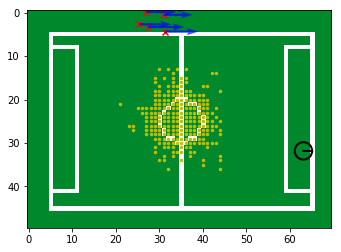

73
255 pos_map values


<Figure size 432x288 with 0 Axes>

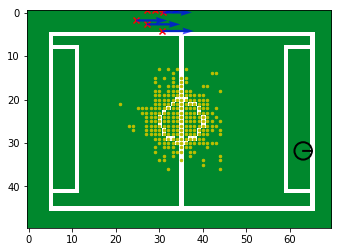

74
255 pos_map values


<Figure size 432x288 with 0 Axes>

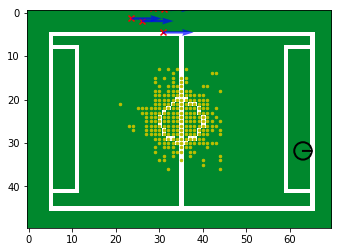

75
255 pos_map values


<Figure size 432x288 with 0 Axes>

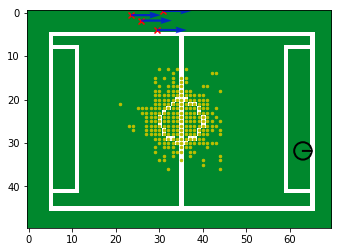

76
255 pos_map values


<Figure size 432x288 with 0 Axes>

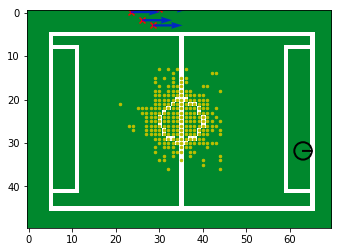

77
255 pos_map values


<Figure size 432x288 with 0 Axes>

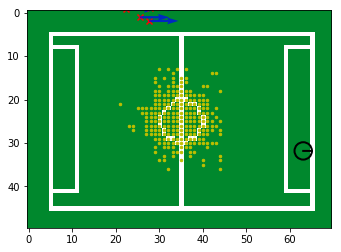

78
255 pos_map values


<Figure size 432x288 with 0 Axes>

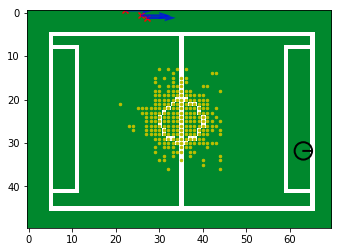

In [ ]:
image_name, x, y, th = read_csv('./continuous_data_center_circle_to_before_goal_log.csv')

dami = '../images/field.png'
tool = make_random_selfdata.MakeRandomSelfdata(dami)
plot_cls = Plot(tool)
p_num = 10
init_x, init_y = plot_cls.convertVrepPos2DisplayPosValue(x[0], y[0])
init_pose = [init_x, init_y, th[0]]
robot = Robot(init_pose[0],init_pose[1],init_pose[2])
cvae = CVAE()
particles = [Particle(init_pose, 1.0/p_num) for i in range(p_num)]
#print(particles[0].pose, particles[0].weight)
n = 0
#size = 20

d_kido = np.zeros((2,1), dtype =np.float32)
d_particle = np.zeros((2,1), dtype =np.float32)

for n in range(len(x)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    d_p = np.empty((0,2), dtype=np.float32)
    print(n)
    if(n==0):
        cx, cy = plot_cls.convertVrepPos2DisplayPosValue(x[0], y[0])
        plot_cls.plotUpdate(cx, cy, th[n], particles, ax)
        plt.cla()
        plt.clf()
    else:
        #--------motion update----------#
        #robotのmotion_update
        cx, cy, cth = robot.motion_update(x[n], y[n], th[n])
        #particleのmotion_update
        for i in range(len(particles)):
            particles[i].pose = particles[i].motion_update(x[n], y[n], th[n], x[n-1], y[n-1], th[n-1])
        #--------observation update----------#
        cvae.pred_CVAE('./continuous_data_center_circle_to_before_goal/'+image_name[n])
        #pos_map, angle_map = cvae.getMaps()
        pos_map, angle_map = cvae.dammyGetMaps()
        d_kido = returnKidoAxisFropmPosMap(pos_map)
        print(pos_map[20,30], 'pos_map values')
        '''
        print(pos_map[20,30], 'pos_map values')
        plt.imshow(pos_map)
        plt.show()
        plt.imshow(angle_map)
        plt.show()
        '''
        for i in range(len(particles)):
            particles[i].observation_update(pos_map, angle_map)
            d_p = np.append(d_p, [[particles[i].pose[0],particles[i].pose[1]]], axis=0)
        plt.scatter(d_p[:,0]+plot_cls.field_mergin, d_p[:,1]+plot_cls.field_mergin, color='red', marker='x')
        plt.scatter(d_kido[:,0]+plot_cls.field_mergin, d_kido[:,1]+plot_cls.field_mergin, color='y', marker='o', s=6)
        #--------plot update----------#
        plot_cls.plotUpdate(cx,cy,cth, particles, ax)
        plt.cla()
        plt.clf()

#パーティクルを適当にまく
#モーションアップデートする（真値の1番目ー0番目）
#1番目の画像を使ってCVAEのゆうど関数から重みの更新
#これを繰り返す

[[1. 2.]
 [4. 5.]]
[18.5893032179967, -11.753057410309854]
[23.223351821022735, -17.86552485555598]
[14.126323350650882, -10.961266708284196]
[19.187119251573048, -15.354546005528045]
[19.316538206635624, -11.007873707146135]
[21.850009954910547, -16.007737763211622]
[16.7126555040139, -3.2810213273037814]
[19.627112979337873, -18.76873633359561]
[17.1703794743715, -11.547320747958398]
[19.55753765719026, -16.16281019504776]


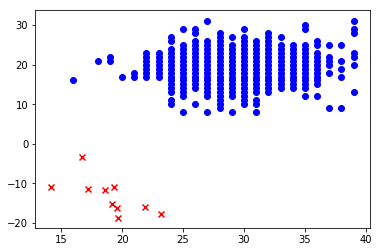

In [9]:
arr = np.empty((0,2), dtype=np.float32)
arr = np.append(arr, np.array([[1, 2]]), axis=0)
arr = np.append(arr, np.array([[4, 5]]), axis=0)
print(arr)
def returnKidoAxisFropmPosMap(pos_map):
    kido = np.empty((0,2), dtype=np.float32)
    for h in range(pos_map.shape[0]):
        for w in range(pos_map.shape[1]):
            if(pos_map[h, w] > 0):
                #print("!!!!!!!!!!!!")
                #kido = [w,h]
                kido = np.append(kido, np.array([[w,h]]), axis=0)
                #print(kido)
    #print(kido)
    return kido

d_p = np.empty((0,2), dtype=np.float32)
cvae.pred_CVAE('./continuous_data_center_circle_to_before_goal/'+image_name[1])
pos_map, angle_map = cvae.dammyGetMaps()
d_kido = returnKidoAxisFropmPosMap(pos_map)

for i in range(len(particles)):
    print([particles[i].pose[0],particles[i].pose[1]])
    #print(particles[i].pose[0][i])
    d_p = np.append(d_p, [[particles[i].pose[0],particles[i].pose[1]]], axis=0)
plt.scatter(d_p[:,0], d_p[:,1], color='red', marker='x')
plt.scatter(d_kido[:,0], d_kido[:,1], color='blue', marker='o')